# UNSW Dataset Analysis

* **Author:** Patrik Goldschmidt (igoldschmidt@fit.vut.cz)
* **Project:** Network Intrusion Datasets: A Survey, Limitations, and Recommendations
* **Date:** 2023

This notebook was created as a part of other project, so files with custom classes like Dataset exist. Since this notebook is made only for demonstrative purposes and not supposed to be re-run as is, we kept it as it is. Further data analysis (after loading) is unaffected.

This notebook also demonstrates strange errors found in the data - e.g., apparently data from EIGRP protocol containing Fuzzers, Backdoors, DoS, and other attack types - creating a rather nonsense-like data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sys
sys.path.append('..')

import config.dataset as dsetcfg
import dataset as dset

pd.set_option("display.max_columns", None)

%load_ext autoreload
%autoreload 2

In [ ]:
# Define columns and their types for the loading
DSET_FIELDS_UNSW = [
    'srcip',            # Source IP address
    'sport',            # Source port number
    'dstip',            # Destination IP address
    'dport',            # Destination port number
    'proto',            # Transaction protocol
    'state',            # Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT,
                        # MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)
    'dur',              # Record total duration
    'sbytes',           # Source to destination transaction bytes
    'dbytes',           # Destination to source transaction bytes
    'sttl',             # Source to destination time to live value
    'dttl',             # Destination to source time to live value
    'sloss',            # Source packets retransmitted or dropped
    'dloss',            # Destination packets retransmitted or dropped
    'service',          # http, ftp, smtp, ssh, dns, ftp-data, irc  and (-) if not much used service
    'sload',            # Source bits per second
    'dload',            # Destination bits per second
    'spkts',            # Source to destination packet count
    'dpkts',            # Destination to source packet count
    'swin',             # Source TCP window advertisement value
    'dwin',             # Destination TCP window advertisement value
    'stcpb',            # Source TCP base sequence number
    'dtcpb',            # Destination TCP base sequence number
    'smeansz',          # Mean of the ?ow packet size transmitted by the src
    'dmeansz',          # Mean of the ?ow packet size transmitted by the dst
    'trans_depth',      # Represents the pipelined depth into the connection of http request/response transaction
    'res_bdy_len',      # Actual uncompressed content size of the data transferred from the server's http service
    'sjit',             # Source jitter (mSec)
    'djit',             # Destination jitter (mSec)
    'stime',            # Record start time
    'ltime',            # Record last time
    'sintpkt',          # Source interpacket arrival time (mSec)
    'dintpkt',          # Destination interpacket arrival time (mSec)
    'tcprtt',           # TCP connection setup round-trip time, the sum of synack and ackdata
    'synack',           # TCP connection setup time, the time between the SYN and the SYN_ACK packets
    'ackdat',           # TCP connection setup time, the time between the SYN_ACK and the ACK packets
    'is_sm_ips_ports',  # If source (1) and destination (3)IP addresses equal and port numbers (2)(4) equal then
                        # this variable takes value 1 else 0
    'ct_state_ttl',     # No. for each state (6) according to specific range of values for source/destination time
                        # to live (10) (11)
    'ct_flw_http_mthd', # No. of flows that has methods such as Get and Post in http service
    'is_ftp_login',     # If the ftp session is accessed by user and password then 1 else 0
    'ct_ftp_cmd',       # No of flows that has a command in ftp session
    'ct_srv_src',       # No. of connections that contain the same service (14) and source address (1) in 100
                        # connections according to the last time (26)
    'ct_srv_dst',       # No. of connections that contain the same service (14) and destination address (3) in 100
                        # connections according to the last time (26)
    'ct_dst_ltm',       # No. of connections of the same dstip (3) in 100 connections according to the last time (26)
    'ct_src_ltm',       # No. of connections of the same srcip (1) in 100 connections according to the last time (26)
    'ct_src_dport_ltm', # No of connections of the same srcip (1) and the dstport (4) in 100 connections according
                        # to the last time (26)
    'ct_dst_sport_ltm', # No of connections of the same dstip (3) and the srcport (2) in 100 connections according
                        # to the last time (26)
    'ct_dst_src_ltm',   # No of connections of the same srcip (1) and the dstip (3) address in in 100 connections
                        # according to the last time (26)
    'attack_cat',       # The name of each attack category - Fuzzers, Analysis, Backdoors, DoS Exploits, Generic,
                        # Reconnaissance, Shellcode and Worms
    'label'             # Binary target class
]

# Data are messy, trying for manual data cast such as this might raise arrors
DSET_DTYPES_UNSW = {
    'srcip'            : object,
    'sport'            : object,
    'dstip'            : object,
    'dport'            : object,
    'proto'            : object,
    'state'            : object,
    'dur'              : np.float32,
    'sbytes'           : np.uint16,
    'dbytes'           : np.uint16,

    'sttl'             : np.uint8,
    'dttl'             : np.uint8,
    'sloss'            : np.uint16,
    'dloss'            : np.uint16,
    'service'          : object,
    'sload'            : np.float32,
    'dload'            : np.float32,
    'spkts'            : np.uint32,
    'dpkts'            : np.uint32,
    'swin'             : np.uint16,
    'dwin'             : np.uint16,
    'stcpb'            : np.uint16,
    'dtcpb'            : np.uint16,
    'smeansz'          : np.uint32,
    'dmeansz'          : np.uint32,
    'trans_depth'      : np.uint16,
    'res_bdy_len'      : np.uint16,
    'sjit'             : np.float32,
    'djit'             : np.float32,
    'stime'            : np.uint32,
    'ltime'            : np.uint32,
    'sintpkt'          : np.float32,
    'dintpkt'          : np.float32,
    'tcprtt'           : np.float32,
    'synack'           : np.float32,
    'ackdat'           : np.float32,
    'is_sm_ips_ports'  : np.bool8,
    'ct_state_ttl'     : np.uint16,
    'ct_flw_http_mthd' : np.uint16,
    'is_ftp_login'     : np.bool8,
    'ct_ftp_cmd'       : np.uint16,
    'ct_srv_src'       : np.uint16,
    'ct_srv_dst'       : np.uint8,
    'ct_dst_ltm'       : np.uint8,
    'ct_src_ltm'       : np.uint8,
    'ct_src_dport_ltm' : np.uint8,
    'ct_dst_sport_ltm' : np.uint8,
    'ct_dst_src_ltm'   : np.uint8,
    'attack_cat'       : object,
    'label'            : np.bool8,
}

In [2]:
BASE_FOLDER = '/data/kinit/gold_data/unsw-nb15/CSVs'
DATASET_FILE1 = 'UNSW-NB15_1.csv'
DATASET_FILE2 = 'UNSW-NB15_2.csv'
DATASET_FILE3 = 'UNSW-NB15_3.csv'
DATASET_FILE4 = 'UNSW-NB15_4.csv'

UNSW_FILES = [
    os.path.join(BASE_FOLDER, DATASET_FILE1),
    os.path.join(BASE_FOLDER, DATASET_FILE2),
    os.path.join(BASE_FOLDER, DATASET_FILE3),
    os.path.join(BASE_FOLDER, DATASET_FILE4),
]

In [4]:
# We keep the original Dataset class, but otherwise, the data can be loaded in a loop with the headers and types specified above.
# In this case, the data is analyzed on a train data subset, which was randomly split - I know, this might create temporal bias,
# However, back in a day when I was starting my Ph.D., I had no idea about it :(
# Nevertheless, the conclusions presented in this notebook are unafected by it and still valid.
data = dset.Dataset('unsw', random_state=42)
dataset = data.data_train

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             string 
 2   dstip             object 
 3   dport             string 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

In [5]:
dataset.describe()

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,label
count,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,1.191902e+06,1.110168e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06
mean,6.587916e-01,4.339600e+03,3.642759e+04,6.278197e+01,3.076681e+01,5.163921e+00,1.632944e+01,3.695645e+07,2.450861e+06,3.328884e+01,4.272664e+01,1.500887e+02,1.497459e+02,1.261701e+09,1.261766e+09,1.242536e+02,2.766719e+02,8.325318e-02,4.242118e+03,1.589037e+03,7.300755e+02,1.423261e+09,1.423261e+09,1.933225e+02,7.882476e+01,6.180475e-03,3.287595e-03,2.892880e-03,1.651544e-03,2.611546e-01,2.345856e-01,3.969940e-02,9.206988e+00,8.988958e+00,6.439103e+00,6.900986e+00,4.642139e+00,3.592729e+00,6.845886e+00,1.264870e-01
std,1.392493e+01,5.640599e+04,1.610960e+05,7.462277e+01,4.285089e+01,2.251707e+01,5.659474e+01,1.186043e+08,4.224863e+06,7.628388e+01,1.215020e+02,1.254824e+02,1.255438e+02,1.422027e+09,1.422139e+09,1.519162e+02,3.356166e+02,3.500045e-01,4.750053e+04,1.691036e+04,3.438558e+03,1.134449e+06,1.134448e+06,2.779163e+03,1.433191e+03,4.615863e-02,2.593570e-02,2.394668e-02,4.060563e-02,6.830974e-01,7.940924e-01,1.996589e-01,1.083676e+01,1.082249e+01,8.162034e+00,8.205062e+00,8.477579e+00,6.174445e+00,1.125828e+01,3.323975e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421927e+09,1.421927e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.037000e-03,2.000000e+02,1.780000e+02,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00,1.353963e+05,1.191594e+04,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,6.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421952e+09,1.421952e+09,9.000000e-03,6.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.586100e-02,1.470000e+03,1.820000e+03,3.100000e+01,2.900000e+01,3.000000e+00,4.000000e+00,5.893038e+05,5.893179e+05,1.200000e+01,1.200000e+01,2.550000e+02,2.550000e+02,6.397250e+08,6.384172e+08,7.300000e+01,8.900000e+01,0.000000e+00,0.000000e+00,1.912490e+01,2.653561e+00,1.424227e+09,1.424227e+09,4.682620e-01,4.147550e-01,6.130000e-04,4.830000e-04,1.220000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00
75%,2.145545e-01,3.182000e+03,1.489400e+04,3.100000e+01,2.900000e+01,7.000000e+00,1.400000e+01,2.039923e+06,2.925974e+06,4.400000e+01,4.200000e+01,2.550000e+02,2.550000e+02,2.467160e+09,2.469411e+09,1.320000e+02,5.650000e+02,0.000000e+00,0.000000e+00,4.137935e+02,6.350857e+01,1.424245e+09,1.424245e+09,7.351427e+00,6.202100e+00,7.020000e-04,5.540000e-04,1.400000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,6.000000e+00,7.000000e+00,2.000000e+00,1.000000e+00,5.000000e+

In [6]:
dataset.head()

,srcip,sport,dstip,dport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,<NA>,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,<NA>,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,<NA>,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,<NA>,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,<NA>,0


In [7]:
list(pd.unique(dataset['attack_cat']))

[<NA>,
 'Exploits',
 'Reconnaissance',
 'DoS',
 'Generic',
 'Shellcode',
 'Fuzzers',
 'Worms',
 'Backdoors',
 'Analysis',
 'Backdoor']

Replace NaN values with benign tag + attack_cat labels are inconsistent, need to replace as well.

In [8]:
dataset.replace(np.NaN, 'benign', inplace=True)

In [9]:
list(pd.unique(dataset['attack_cat']))

['benign',
 'Exploits',
 'Reconnaissance',
 'DoS',
 'Generic',
 'Shellcode',
 'Fuzzers',
 'Worms',
 'Backdoors',
 'Analysis',
 'Backdoor']

In [10]:
# There is attack category Backdoor and Backdoors... This is probably the same, check its distribution
# This will be normalized to 'Backdoors' during the preprocessing
print(len(dataset[dataset['attack_cat'] == 'Backdoor']))
print(len(dataset[dataset['attack_cat'] == 'Backdoors']))

1795
534


In [11]:
dataset.head()

,srcip,sport,dstip,dport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,benign,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,benign,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,benign,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,benign,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,benign,0


## Test whether the error is in dataset or in the merging
`attack_cat` labels are problematic, as there are spaces in between, producing different label names and thus different labels for ML models.
(This was computed previously, so cells above are already fine, but the `final_frame` below shows the problem.

Did the problem arise due to merging or is the original dataset flawed as well?

In [ ]:
unsw_frames = []

for file in UNSW_FILES:
    unsw_frames.append(pd.read_csv(file), names=DSET_FIELDS_UNSW)

final_frame = pd.concat(unsw_frames)

D:\User Files\Goldy\Desktop\still gramko\kinit\.kinit-env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\User Files\Goldy\Desktop\still gramko\kinit\.kinit-env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
final_frame['attack_cat'].unique()

array([nan, 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode',
       ' Fuzzers', 'Worms', 'Backdoors', 'Analysis', ' Reconnaissance ',
       'Backdoor', ' Fuzzers ', ' Shellcode '], dtype=object)

As we can see, the problem is in the labeling itself. E.g. `Shellcode` and ` Shellcode ` are two different labels but they should point to the same category. The file will have to be edited with regex to normalize attack categories.

## Analysis of Fixed Dataset

In [13]:
# Categorical variables unique count
dataset[['proto', 'state', 'service']].nunique()

proto      135
state       16
service     13
dtype: int64

### Protocols (And Their Problems)

Hmm, that's quite a lot. What are these values to be precise?

In [14]:
dataset['proto'].unique()

array(['udp', 'arp', 'tcp', 'ospf', 'icmp', 'igmp', 'sctp', 'udt', 'sep',
       'sun-nd', 'swipe', 'mobile', 'pim', 'rtp', 'ipnip', 'ip', 'ggp',
       'st2', 'egp', 'cbt', 'emcon', 'nvp', 'igp', 'xnet', 'argus',
       'bbn-rcc', 'chaos', 'pup', 'hmp', 'mux', 'dcn', 'prm', 'trunk-1',
       'xns-idp', 'trunk-2', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'iso-tp4',
       'netblt', 'mfe-nsp', 'merit-inp', '3pc', 'xtp', 'idpr', 'tp++',
       'ddp', 'idpr-cmtp', 'ipv6', 'il', 'idrp', 'ipv6-frag', 'sdrp',
       'ipv6-route', 'gre', 'rsvp', 'mhrp', 'bna', 'esp', 'i-nlsp',
       'narp', 'ipv6-no', 'tlsp', 'skip', 'ipv6-opts', 'any', 'cftp',
       'sat-expak', 'kryptolan', 'rvd', 'ippc', 'sat-mon', 'ipcv', 'visa',
       'cpnx', 'cphb', 'wsn', 'pvp', 'br-sat-mon', 'wb-mon', 'wb-expak',
       'iso-ip', 'secure-vmtp', 'vmtp', 'vines', 'ttp', 'nsfnet-igp',
       'dgp', 'tcf', 'eigrp', 'sprite-rpc', 'larp', 'mtp', 'ax.25',
       'ipip', 'micp', 'aes-sp3-d', 'encap', 'etherip', 'pri-enc', 'gmtp'

That's a lot of protocols... cannot we categorize them somehow so the dimensionality increase wouldn't be so tragic?

In [15]:
dataset.groupby('proto').size().sort_values(ascending=False).head(10)

proto
tcp     1495074
udp      990435
unas      16202
arp       10064
ospf       7798
sctp       1525
icmp        524
any         411
gre         324
rsvp        274
dtype: int64

In [16]:
dataset.groupby('proto').size().sort_values(ascending=False).tail(10)

proto
igp          137
ifmp         137
idrp         137
idpr-cmtp    137
idpr         137
zero         137
igmp          64
udt            8
rtp            7
esp            2
dtype: int64

That's quite a difference, we surely don't need to encode all of them...

In [17]:
# How many attacks are there?
attacks_cnt = len(dataset[dataset['label'] == 1])
attacks_cnt

321283

Do we want traffic like ARP, OSPF, SCTP, GRE,... to be classified at all? (GRE floods exist indeed, but number of entries is miserable...)

At first, we will care about how are these protocol categories linked to the attack categories.

In [18]:
proto_names = list(dataset.groupby('proto').size().sort_values(ascending=False).index)
print("{:12} {:>10} {:>15} {:>15}".format("PROTOCOL", "ATT_CNT", "PR_ATT_RATIO", "TOT_ATT_RATIO"))

for pname in proto_names:
    proto_cnt         = len(dataset[dataset['proto'] == pname])
    proto_attacks_cnt = len(dataset.loc[(dataset['label'] == 1) & (dataset['proto'] == pname)])

    print("{:12} {:10} {:15.3f} {:15.3f}".format(pname, proto_attacks_cnt, proto_attacks_cnt / proto_cnt, proto_attacks_cnt / attacks_cnt))

PROTOCOL        ATT_CNT    PR_ATT_RATIO   TOT_ATT_RATIO
tcp               58184           0.039           0.181
udp              223750           0.226           0.696
unas              16202           1.000           0.050
arp                   0           0.000           0.000
ospf               3278           0.420           0.010
sctp               1525           1.000           0.005
icmp                  0           0.000           0.000
any                 411           1.000           0.001
gre                 324           1.000           0.001
rsvp                274           1.000           0.001
ipv6                272           1.000           0.001
mobile              262           1.000           0.001
pim                 262           1.000           0.001
swipe               262           1.000           0.001
sun-nd              262           1.000           0.001
sep                 260           1.000           0.001
sat-mon             137           1.000         

That's weird, lot of protocols have their number exactly at 137 and all of them are malicious. There is indeed a biased data sample... Let's analyze further.

In [19]:
dataset[dataset['proto'] == 'egp'].head()

,srcip,sport,dstip,dport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
81038,175.45.176.1,0,149.171.126.12,0,egp,INT,0.000005,180,0,254,0,0,0,-,144000000.0,0.0,2,0,0,0,0,0,90,0,0,0,0.0,0.0,1421930644,1421930644,0.005,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,8,6,5,4,4,4,4,Analysis,1
81039,175.45.176.1,0,149.171.126.12,0,egp,INT,0.000005,180,0,254,0,0,0,-,144000000.0,0.0,2,0,0,0,0,0,90,0,0,0,0.0,0.0,1421930644,1421930644,0.005,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,8,6,5,4,4,4,4,Backdoors,1
81040,175.45.176.1,0,149.171.126.12,0,egp,INT,0.000005,180,0,254,0,0,0,-,144000000.0,0.0,2,0,0,0,0,0,90,0,0,0,0.0,0.0,1421930644,1421930644,0.005,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,8,6,5,4,4,4,4,Exploits,1
81041,175.45.176.1,0,149.171.126.12,0,egp,INT,0.000005,180,0,254,0,0,0,-,144000000.0,0.0,2,0,0,0,0,0,90,0,0,0,0.0,0.0,1421930644,1421930644,0.005,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,8,6,5,4,4,4,4,DoS,1
81042,175.45.176.1,0,149.171.126.12,0,egp,INT,0.000005,180,0,254,0,0,0,-,144000000.0,0.0,2,0,0,0,0,0,90,0,0,0,0.0,0.0,1421930644,1421930644,0.005,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,8,6,5,4,4,4,4,Exploits,1


This is some nonsense... Entries are exactly the same except the attack category...

In [20]:
dataset[dataset['proto'] == 'egp'].drop('attack_cat', axis=1).duplicated().value_counts()

True     130
False      7
dtype: int64

So out of 137 entries with protocol `egp`, 130 are duplicated with the exception of attack category. What if we keep it?

Although I think it is desirable to be dropped, as there are timestamps `stime` and `dtime` that are thus duplicated as well...

In [21]:
dataset[dataset['proto'] == 'egp'].duplicated().value_counts()

True     91
False    46
dtype: int64

It just looks like the authors duplicated some entries and just changed the attack category...

In [22]:
# Drop the attack category and count the number of duplicates across the dataframe
dataset_nocat = dataset.drop('attack_cat', axis=1)

print("{:12} {:>10} {:>12}".format("PROTOCOL", "DULPICATES", "DUPL_RATIO"))

for pname in proto_names:
    proto_cnt = len(dataset[dataset['proto'] == pname])
    dupl_stat = dataset_nocat[dataset_nocat['proto'] == pname].duplicated().value_counts()
    dupl_cnt  = dupl_stat[True] if (True in dupl_stat.index) else 0
    print("{:12} {:10} {:12.3f}".format(pname, dupl_cnt, dupl_cnt / proto_cnt))

PROTOCOL     DULPICATES   DUPL_RATIO
tcp               46495        0.031
udp              402505        0.406
unas              15474        0.955
arp                3406        0.338
ospf               4661        0.598
sctp               1449        0.950
icmp                 26        0.050
any                 390        0.949
gre                 309        0.954
rsvp                260        0.949
ipv6                258        0.949
mobile              249        0.950
pim                 249        0.950
swipe               249        0.950
sun-nd              249        0.950
sep                 247        0.950
sat-mon             130        0.949
rdp                 130        0.949
qnx                 130        0.949
rvd                 130        0.949
sat-expak           130        0.949
pvp                 130        0.949
scps                130        0.949
pup                 130        0.949
sccopmce            130        0.949
3pc                 130        0.949
p

Ok, so almost all the suspicious protocols have the same ratio of duplicates... I wonder if they are duplicated between each other...

Lets choose 3 random protocols from the suspicious ones, merge them and see the results.

In [23]:
# Choose 1 "random" suspicious protocol for further reference
dataset[dataset['proto'] == 'chaos'].duplicated().value_counts()

True     91
False    46
dtype: int64

In [24]:
# Now, choose 3 protocols, drop the protocol column and see duplicates...
proto_chaos = dataset[dataset['proto'] == 'chaos']
proto_smp   = dataset[dataset['proto'] == 'smp']
proto_encap = dataset[dataset['proto'] == 'encap']

suspicious = pd.concat([proto_chaos, proto_smp, proto_encap])

In [25]:
# Let's see the number of duplicates this way
suspicious.drop('proto', axis=1).duplicated().value_counts()

True     273
False    138
dtype: int64

Ok, so this hypothesis was not correct, and field between protocols are seemingly different, let's see on example

In [26]:
proto_chaos.head(2)

,srcip,sport,dstip,dport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
81153,175.45.176.1,0,149.171.126.12,0,chaos,INT,0.000011,200,0,254,0,0,0,-,72727272.0,0.0,2,0,0,0,0,0,100,0,0,0,0.0,0.0,1421930645,1421930645,0.011,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,14,14,14,15,14,14,14,Analysis,1
81154,175.45.176.1,0,149.171.126.12,0,chaos,INT,0.000011,200,0,254,0,0,0,-,72727272.0,0.0,2,0,0,0,0,0,100,0,0,0,0.0,0.0,1421930645,1421930645,0.011,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,14,14,14,15,14,14,14,Backdoors,1


In [27]:
proto_smp.head(2)

,srcip,sport,dstip,dport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
84492,175.45.176.1,0,149.171.126.12,0,smp,INT,0.000006,200,0,254,0,0,0,-,80000000.0,0.0,2,0,0,0,0,0,100,0,0,0,0.0,0.0,1421930717,1421930717,0.01,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,14,14,4,8,4,4,4,Analysis,1
84493,175.45.176.1,0,149.171.126.12,0,smp,INT,0.000006,200,0,254,0,0,0,-,80000000.0,0.0,2,0,0,0,0,0,100,0,0,0,0.0,0.0,1421930717,1421930717,0.01,0.0,0.0,0.0,0.0,0,2,0.0,0.0,0,14,14,4,8,4,4,4,Backdoors,1


Ok, they are different, but this is veeeeery suspicious anyway and the dataset is definitely flawed somehow, as some protocols represent only attack traffic...

Let's use some domain knowledge... EIGRP is a routing protocol and only a limited number of attacks should be available via it. What are the declared attacks in the dataset?

In [28]:
dataset[dataset['proto'] == 'eigrp']['attack_cat'].value_counts()

Exploits          55
DoS               44
Fuzzers           10
Analysis           8
Reconnaissance     7
Generic            6
Backdoor           5
Backdoors          2
Name: attack_cat, dtype: Int64

According to [https://www.cvedetails.com/vulnerability-list/vendor_id-1509/Extended-Interior-Gateway-Routing-Protocol.html](EIGRP CVE Webpage), the only exploits against EIGRP are DoS type, although reconaissance and network analysis could potentially be made... Just to make sure, what is the attack category distribution in different protocol?

In [29]:
dataset[dataset['proto'] == 'etherip']['attack_cat'].value_counts()

Exploits          55
DoS               44
Fuzzers           10
Analysis           8
Reconnaissance     7
Generic            6
Backdoor           5
Backdoors          2
Name: attack_cat, dtype: Int64

Ok, this is the same as for EIGRP... Nothing sketchy yet?

In [30]:
# Compare protocol types if they don't have the same attack distribution...
analyzed_protos = [pname for pname in list(dataset['proto'].unique()) if len(dataset[dataset['proto'] == pname]) == 137]
attcks_template = dataset[dataset['proto'] == 'etherip']['attack_cat'].value_counts()
analyzed_protos.sort()

In [31]:
results = {}

for pname in analyzed_protos:
    attacks_df = dataset[dataset['proto'] == pname]['attack_cat'].value_counts()
    results[pname] = attcks_template.equals(attacks_df)

In [32]:
for proto, equal in results.items():
    print("{:12} {}".format(proto, equal))

3pc          True
a/n          True
aes-sp3-d    True
argus        True
aris         True
ax.25        True
bbn-rcc      True
bna          True
br-sat-mon   True
cbt          True
cftp         True
chaos        True
compaq-peer  True
cphb         True
cpnx         True
crtp         True
crudp        True
dcn          True
ddp          True
ddx          True
dgp          True
egp          True
eigrp        True
emcon        True
encap        True
etherip      True
fc           True
fire         True
ggp          True
gmtp         True
hmp          True
i-nlsp       True
iatp         True
ib           True
idpr         True
idpr-cmtp    True
idrp         True
ifmp         True
igp          True
il           True
ip           True
ipcomp       True
ipcv         True
ipip         True
iplt         True
ipnip        True
ippc         True
ipv6-frag    True
ipv6-no      True
ipv6-opts    True
ipv6-route   True
ipx-n-ip     True
irtp         True
isis         True
iso-ip       True
iso-tp4   

OK, all elements that contain the same number of items (137) contain exactly the same attacks... Therefore, the labeling is obviously flawed and this entries cannot be absolutely relied on.

### State

In [33]:
dataset['state'].unique()

array(['CON', 'INT', 'FIN', 'URH', 'REQ', 'ECO', 'RST', 'CLO', 'TXD',
       'URN', 'no', 'ACC', 'PAR', 'MAS', 'TST', 'ECR'], dtype=object)

In [34]:
dataset['state'].value_counts()

FIN    1478689
CON     560588
INT     490471
REQ       9043
RST        528
ECO        337
CLO        161
URH        108
ACC         43
PAR         30
TST          9
ECR          9
URN          8
no           8
MAS          8
TXD          7
Name: state, dtype: int64

States with very little number of entries could be grouped under a single one. Check attacks distribution.

In [35]:
attacks_cnt = len(dataset[dataset['label'] == 1])
state_names = list(dataset['state'].value_counts().index)
print("{:6} {:>10} {:>15} {:>15}".format("State", "ATT_CNT", "ST_ATT_RATIO", "TOT_ATT_RATIO"))

for state in state_names:
    state_cnt         = len(dataset[dataset['state'] == state])
    state_attacks_cnt = len(dataset.loc[(dataset['label'] == 1) & (dataset['state'] == state)])

    print("{:6} {:10} {:15.3f} {:15.3f}".format(state, state_attacks_cnt, state_attacks_cnt / state_cnt, state_attacks_cnt / attacks_cnt))

State     ATT_CNT    ST_ATT_RATIO   TOT_ATT_RATIO
FIN         57923           0.039           0.180
CON          1495           0.003           0.005
INT        260620           0.531           0.811
REQ          1229           0.136           0.004
RST            13           0.025           0.000
ECO             0           0.000           0.000
CLO             1           0.006           0.000
URH             0           0.000           0.000
ACC             2           0.047           0.000
PAR             0           0.000           0.000
TST             0           0.000           0.000
ECR             0           0.000           0.000
URN             0           0.000           0.000
no              0           0.000           0.000
MAS             0           0.000           0.000
TXD             0           0.000           0.000


As states with lower count have no attacks at all, they can be more-or-less safely grouped together.
In addition, we can see that connection with state `INT` contribute to more than 80% of all attacks, making the job for classifiers rather easy.

### Service

In [36]:
dataset['service'].unique()

array(['dns', '-', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3',
       'snmp', 'ssl', 'irc', 'radius', 'dhcp'], dtype=object)

Is this necessary if we use our port categorization preprocessing technique? Do we want DHCP traffic at all?

In [37]:
dataset['service'].value_counts()

-           1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: service, dtype: int64

In [38]:
# Check Attack distribution
attacks_cnt = len(dataset[dataset['label'] == 1])
serv_names = list(dataset['service'].value_counts().index)
print("{:8} {:>10} {:>15} {:>15}".format("SERVICE", "ATT_CNT", "SR_ATT_RATIO", "TOT_ATT_RATIO"))

for service in serv_names:
    serv_cnt         = len(dataset[dataset['service'] == service])
    serv_attacks_cnt = len(dataset.loc[(dataset['label'] == 1) & (dataset['service'] == service)])

    print("{:8} {:10} {:15.3f} {:15.3f}".format(service, serv_attacks_cnt, serv_attacks_cnt / serv_cnt, serv_attacks_cnt / attacks_cnt))

SERVICE     ATT_CNT    SR_ATT_RATIO   TOT_ATT_RATIO
-             79877           0.064           0.249
dns          210631           0.269           0.656
http          18847           0.091           0.059
ftp-data       1890           0.015           0.006
smtp           4989           0.061           0.016
ftp            3015           0.061           0.009
ssh              19           0.000           0.000
pop3           1529           0.997           0.005
dhcp            172           1.000           0.001
ssl             142           1.000           0.000
snmp            112           0.991           0.000
radius           30           0.750           0.000
irc              30           0.968           0.000


I think this can be dropped, as we do the same thing with ports and most of the services would be categorized correctly, only SSL could be categorized under web traffic or other based on the port used.

In [39]:
# Are ports correct? Remove '-' service as this produces many ports
for service in set(serv_names) - {'-'}:
    print("{} - {}".format(service, list(dataset[dataset['service'] == service]['dport'].unique())))

ftp - ['21', '2100', '2811']
pop3 - ['110']
ftp-data - ['25740', '11922', '23183', '56538', '6577', '54547', '65419', '64551', '62999', '56301', '57026', '60696', '1968', '33761', '40667', '58215', '29746', '30857', '50128', '54418', '52674', '58459', '65185', '58837', '64661', '65287', '32948', '29419', '4360', '42611', '23027', '41036', '59548', '49160', '49909', '49416', '56220', '54762', '65043', '60119', '51170', '51226', '64583', '52348', '6274', '38520', '54429', '47096', '54430', '59576', '50522', '61932', '19732', '46893', '34044', '60046', '53706', '32284', '64075', '57576', '58464', '50368', '62793', '60253', '59789', '63997', '62540', '17511', '38742', '5658', '58868', '24160', '63906', '37181', '54405', '60207', '52999', '58626', '60693', '65120', '24129', '16578', '42400', '48596', '40095', '11228', '57915', '54329', '51674', '53402', '60345', '58278', '62466', '65080', '50375', '52407', '12409', '33060', '20641', '57230', '15026', '26685', '45510', '64394', '58134', '599

Yeah, mostly correct, although ftp-data service range of ports dynamically opened to serve clients...

## Further Analysis



### Duration
Analyze duration field similar to CIC-2017 refined version to determine which how is the duration represented.

In [40]:
dataset['dur'].describe()

count    2.540047e+06
mean     6.587916e-01
std      1.392493e+01
min      0.000000e+00
25%      1.037000e-03
50%      1.586100e-02
75%      2.145545e-01
max      8.786638e+03
Name: dur, dtype: float64

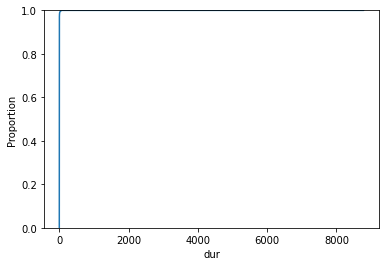

/home/goldy/.local/share/virtualenvs/replication-1-nWqEVJ/lib64/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


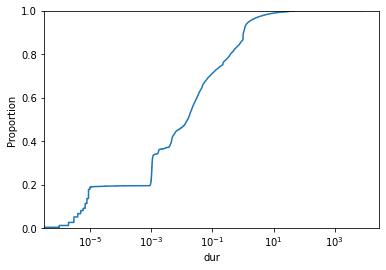

In [44]:
sns.ecdfplot(dataset['dur'])
plt.show()
sns.ecdfplot(dataset['dur'], log_scale=True)
plt.show()

Hoooray, where are no flows with duration less than 0. According to data distribution, this seems like duration in seconds.